**Note:** This notebook can run using TensorFlow 2.5.0

In [1]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


2.6.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFHPKNG/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFHPKNG/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFHPKNG/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


- 이번에는 imdb set으로 돌아가서 학습을 진행

In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

총 3가지 모델을 이용해서 학습을 진행하고 비교
- GRU
- LSTM
- Conv1D

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 54s 59ms/step - loss: 0.5702 - accuracy: 0.6858 - val_loss: 0.3938 - val_accuracy: 0.8338
Epoch 2/50
782/782 [==============================] - 46s 58ms/step - loss: 0.3307 - accuracy: 0.8635 - val_loss: 0.3550 - val_accuracy: 0.8443
Epoch 3/50
782/782 [==============================] - 46s 58ms/step - loss: 0.2532 - accuracy: 0.9025 - val_loss: 0.3751 - val_accuracy: 0.8418
Epoch 4/50
782/782 [==============================] - 46s 58ms/step - loss: 0.2096 - accuracy: 0.9230 - val_loss: 0.3834 - val_accuracy: 0.8384
Epoch 5/50
782/782 [==============================] - 45s 58ms/step - loss: 0.1646 - accuracy: 0.9404 - val_loss: 0.4545 - val_accuracy: 0.8346
Epoch 6/50
782/782 [==============================] - 45s 58ms/step - loss: 0.1265 - accuracy: 0.9564 - val_loss: 0.5425 - val_accuracy: 0.8283
Epoch 7/50
782/782 [==============================] - 45s 58ms/step - loss: 0.0914 - accuracy: 0.9697 - val_loss: 0.5384 - val_accuracy:

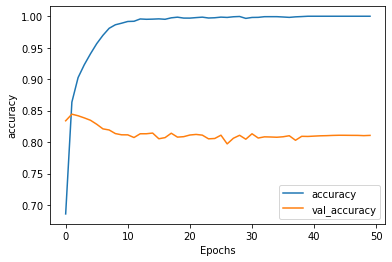

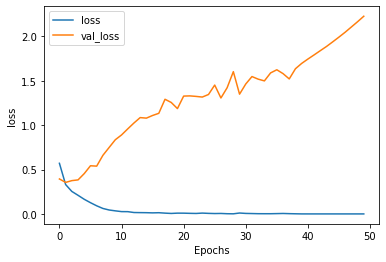

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [9]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


전체적으로 파라미터 수에 차이가 있고, 높은 accuracy를 보이지만, overfitting의 문제점을 세 가지 경우 모두 보여주고 있다.